In [1]:
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

Import data into a dataframe and view head.

In [2]:
kings_county_df = pd.read_csv("data/kc_house_data_train.csv", index_col='Unnamed: 0')
kings_county_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


Check descriptive stats and info about each column

In [3]:
kings_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

### 1. Data Cleaning

- Convert date to DateTime Object
- Took count of ID, if id appeared more than once, sold more than once.
- Drop Unnamed Column and ID: Seems irrelevant
- Drop long/lat, I don't think i can think of any good combination that isn't explained by zip code
- Convert zipcode to string

In [4]:
kings_county_df['date'] = pd.to_datetime(kings_county_df['date'].str.slice(0,8),format="%Y-%m-%d")
dictNumTimesSold = dict(kings_county_df.groupby('id').id.count().sort_values())
kings_county_df['num_times_sold'] = kings_county_df['id'].map(dictNumTimesSold)
kings_county_df.drop(labels =['id', 'lat', 'long'], axis=1, inplace=True)
kings_county_df['zipcode'] = kings_county_df['zipcode'].apply(str)

View extreme numbers and address accordingly. Saw a bedroom of 33 and it looks like a typo so set it to 3 bedrooms. Saw few bathrooms/bedrooms of 0 and it seems outrageous and since they are so few, I decided to drop them. <- Will revisit

In [5]:
kings_county_df.query("bedrooms == 33")

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,num_times_sold
8597,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,1330,4700,1


In [6]:
kings_county_df.at[8597,'bedrooms'] = 3

In [7]:
kings_county_df.bedrooms.value_counts()

3     7865
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

In [8]:
kings_county_df.bathrooms.value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

In [9]:
kings_county_df.query("bathrooms == 0")

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,num_times_sold
483,2015-04-29,355000.0,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,2520,8050,1
1120,2014-06-12,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,2360,4000,1
3032,2014-12-23,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,1060,7200,1
5424,2015-02-05,380000.0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,1470,1399,1
9060,2015-02-17,75000.0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,1160,42882,1
9286,2014-06-24,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,4740,35061,1
10067,2014-09-26,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,1620,22850,1
12982,2014-09-18,484000.0,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,1690,19290,1


In [10]:
kings_county_df = kings_county_df[(kings_county_df.bathrooms != 0) & (kings_county_df.bedrooms != 0) & (kings_county_df.bathrooms >= 1)]


Check for NAs

In [11]:
kings_county_df.isna().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view              0
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
sqft_living15     0
sqft_lot15        0
num_times_sold    0
dtype: int64

In [12]:
kings_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17222 entries, 0 to 17289
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            17222 non-null  datetime64[ns]
 1   price           17222 non-null  float64       
 2   bedrooms        17222 non-null  int64         
 3   bathrooms       17222 non-null  float64       
 4   sqft_living     17222 non-null  int64         
 5   sqft_lot        17222 non-null  int64         
 6   floors          17222 non-null  float64       
 7   waterfront      17222 non-null  int64         
 8   view            17222 non-null  int64         
 9   condition       17222 non-null  int64         
 10  grade           17222 non-null  int64         
 11  sqft_above      17222 non-null  int64         
 12  sqft_basement   17222 non-null  int64         
 13  yr_built        17222 non-null  int64         
 14  yr_renovated    17222 non-null  int64         
 15  zi

View the range for number of bedrooms 

<AxesSubplot:>

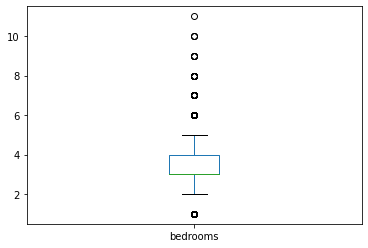

In [13]:
kings_county_df.bedrooms.plot(kind='box')

View the range for number of bathrooms. Mean around 2

<AxesSubplot:>

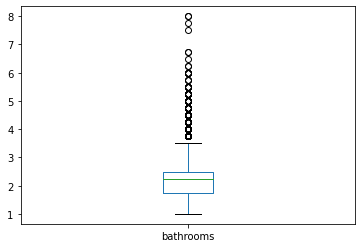

In [14]:
kings_county_df.bathrooms.plot(kind='box')

View average price by bedrooms.

In [15]:
kings_county_df.groupby('bedrooms').price.mean()

bedrooms
1     3.391546e+05
2     4.015678e+05
3     4.657784e+05
4     6.379092e+05
5     7.847411e+05
6     8.377285e+05
7     9.861672e+05
8     1.255600e+06
9     8.167998e+05
10    8.193333e+05
11    5.200000e+05
Name: price, dtype: float64

View number of bedrooms and handle outliers

<AxesSubplot:>

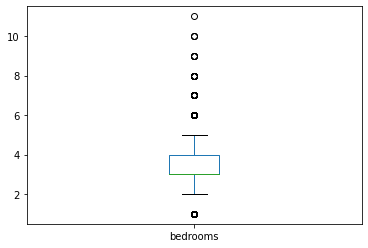

In [16]:
kings_county_df.bedrooms.plot(kind='box')

In [17]:
kings_county_df.bedrooms.value_counts().sort_index()

1      137
2     2186
3     7853
4     5485
5     1283
6      229
7       30
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

Cap the outliers to a certain number

In [18]:
kings_county_df['bedrooms'] = np.where(kings_county_df['bedrooms'] >= 7, 7, kings_county_df['bedrooms'])

In [19]:
kings_county_df.bedrooms.value_counts().sort_index()

1     137
2    2186
3    7853
4    5485
5    1283
6     229
7      49
Name: bedrooms, dtype: int64

View bathrooms grouped by mean

View range for bathrooms

<AxesSubplot:>

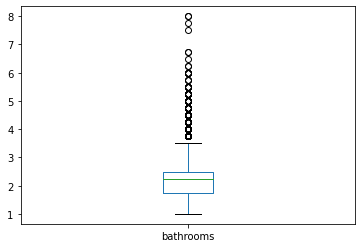

In [20]:
kings_county_df.bathrooms.plot(kind='box')

View count of each bathroom

In [21]:
kings_county_df.bathrooms.value_counts().sort_index()

1.00    3099
1.25       6
1.50    1167
1.75    2431
2.00    1549
2.25    1666
2.50    4319
2.75     896
3.00     592
3.25     455
3.50     591
3.75     135
4.00     107
4.25      64
4.50      76
4.75      16
5.00      17
5.25      11
5.50       7
5.75       3
6.00       6
6.25       2
6.50       1
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

In [22]:
kings_county_df.groupby('bathrooms').price.mean()

bathrooms
1.00    3.463658e+05
1.25    6.010000e+05
1.50    4.074694e+05
1.75    4.582803e+05
2.00    4.557473e+05
2.25    5.372734e+05
2.50    5.568162e+05
2.75    6.545027e+05
3.00    7.149029e+05
3.25    9.656770e+05
3.50    9.289996e+05
3.75    1.198263e+06
4.00    1.309828e+06
4.25    1.532047e+06
4.50    1.328587e+06
4.75    1.817828e+06
5.00    1.749518e+06
5.25    1.866118e+06
5.50    2.803286e+06
5.75    3.143333e+06
6.00    2.946833e+06
6.25    3.094000e+06
6.50    2.238890e+06
6.75    2.734000e+06
7.50    4.500000e+05
7.75    6.885000e+06
8.00    4.990000e+06
Name: price, dtype: float64

Cap the bathrooms to a certain number, 6 in this case.

In [23]:
kings_county_df['bathrooms'] = np.where(kings_county_df['bathrooms']==1.25, 1, kings_county_df['bathrooms'])
kings_county_df['bathrooms'] = np.where(kings_county_df['bathrooms']>=5, 5, kings_county_df['bathrooms'])
kings_county_df.bathrooms.value_counts().sort_index()



1.00    3105
1.50    1167
1.75    2431
2.00    1549
2.25    1666
2.50    4319
2.75     896
3.00     592
3.25     455
3.50     591
3.75     135
4.00     107
4.25      64
4.50      76
4.75      16
5.00      53
Name: bathrooms, dtype: int64

In [24]:
kings_county_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'num_times_sold'],
      dtype='object')

See updated descriptive stats

In [25]:
kings_county_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold
count,1.722200e+04,17222.000000,17222.000000,17222.000000,1.722200e+04,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000
mean,5.416820e+05,3.375915,2.115332,2085.476309,1.522804e+04,1.491290,0.007781,0.237951,3.409012,7.661770,1792.348798,293.127511,1970.872024,83.790733,1989.506329,12849.133724,1.013239
std,3.735401e+05,0.893957,0.757389,918.486549,4.234536e+04,0.538711,0.087867,0.774457,0.650225,1.167142,828.237028,443.674869,29.327414,400.296888,684.637237,27192.749721,0.114299
min,7.800000e+04,1.000000,1.000000,390.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,390.000000,0.000000,1900.000000,0.000000,399.000000,659.000000,1.000000
25%,3.230000e+05,3.000000,1.750000,1430.000000,5.080250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,1490.000000,5110.250000,1.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.638500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,1840.000000,7620.000000,1.000000
75%,6.475000e+05,4.000000,2.500000,2550.000000,1.072000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,570.000000,1996.000000,0.000000,2360.000000,10092.750000,1.000000
max,7.700000e+06,7.000000,5.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,858132.000000,2.000000


In [26]:
continuous = ['price',  'sqft_living', 'sqft_lot',
         'sqft_above', 'sqft_basement',   
       'sqft_living15', 'sqft_lot15']

categorical = ['waterfront','condition','grade',
               'view','bedrooms', 'bathrooms','floors','zipcode']

See the relationship between the continuous variables and the target variable price

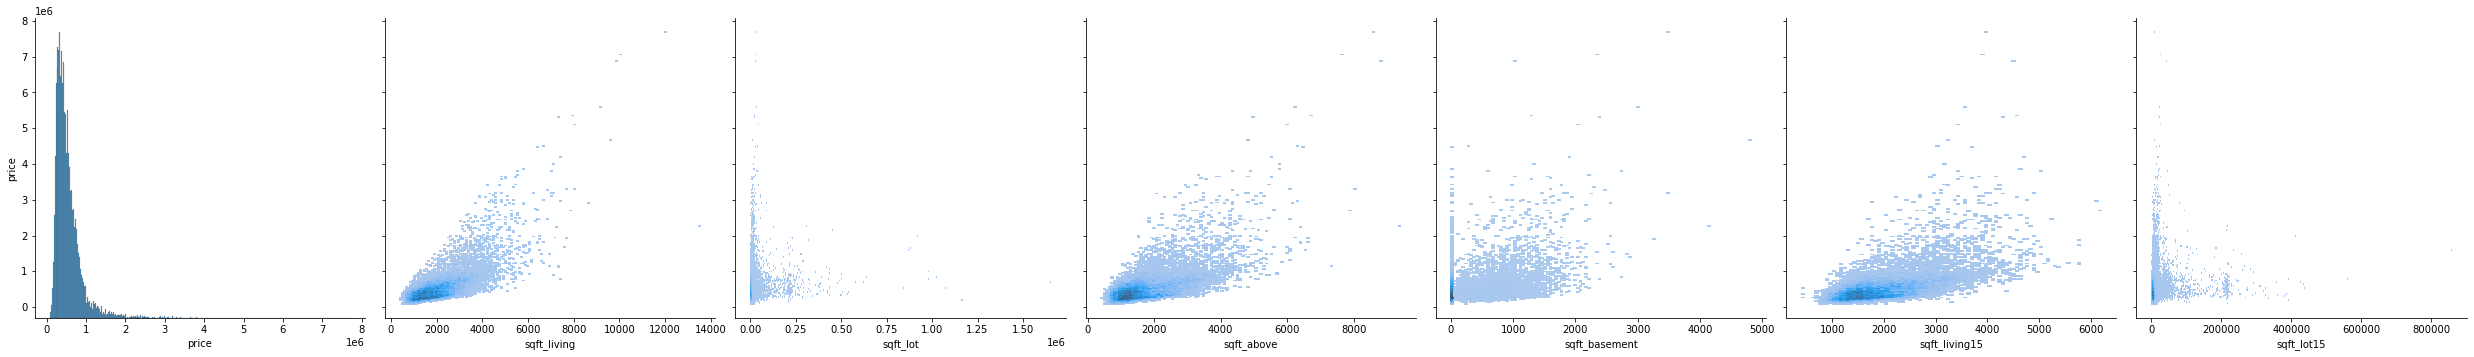

In [27]:
sns.pairplot(data = kings_county_df, y_vars="price", x_vars=continuous, height=5, kind='hist')



View categorical variables against target variable price

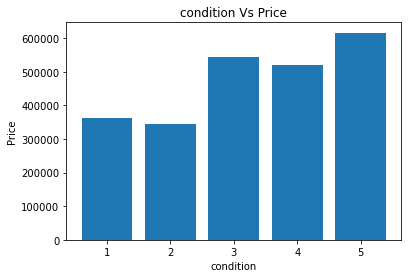

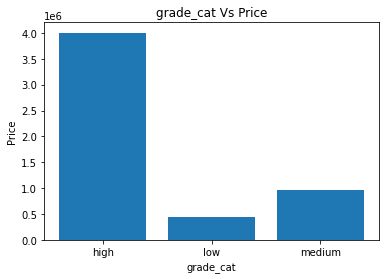

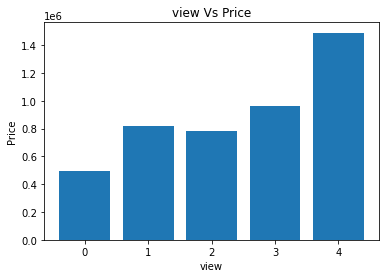

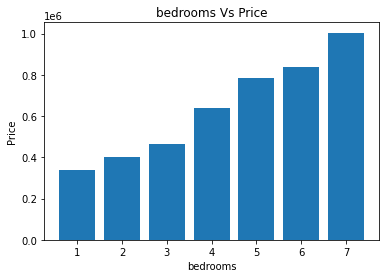

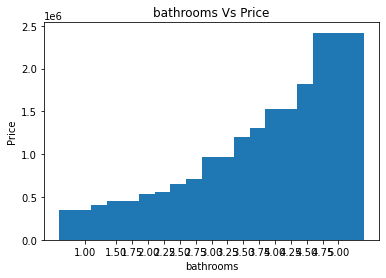

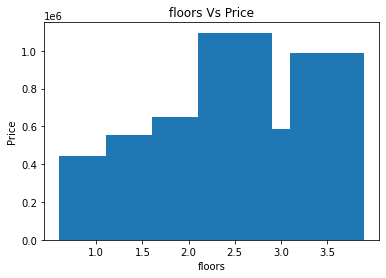

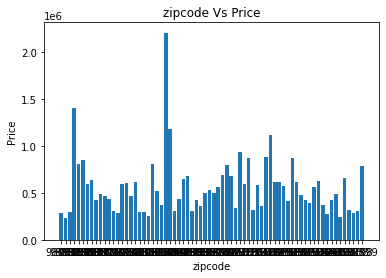

In [92]:
for x in categorical:
    group = kings_county_df.groupby(x).price.mean()
    plt.figure()
    plt.bar(group.index,group.values)
    plt.title(f'{x} Vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)
    plt.xticks(group.index)
    # Show/save figure as desired.
    plt.show()

Categorize grade so it is more linear

In [29]:
conditions = [(kings_county_df['grade'] <= 8),
              (kings_county_df['grade'] <= 12),
             (kings_county_df['grade'] <= 13)]
choices = ['low','medium','high']
kings_county_df['grade_cat'] = np.select(conditions, choices)

View average price by zipcode

<AxesSubplot:>

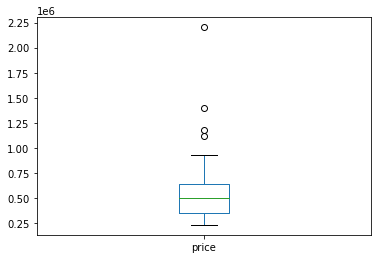

In [30]:
kings_county_df.groupby('zipcode').price.mean().plot(kind='box')

Visualize average price by zipcode

H0: Average price is the same across zipcodes<br>
H1: Average price isn't the same across zipcodes

In [31]:
#alpha = .05
samples = kings_county_df.groupby('zipcode')['price'].apply(list)
stats.f_oneway(*samples)


F_onewayResult(statistic=166.57692359493055, pvalue=0.0)

<BarContainer object of 70 artists>

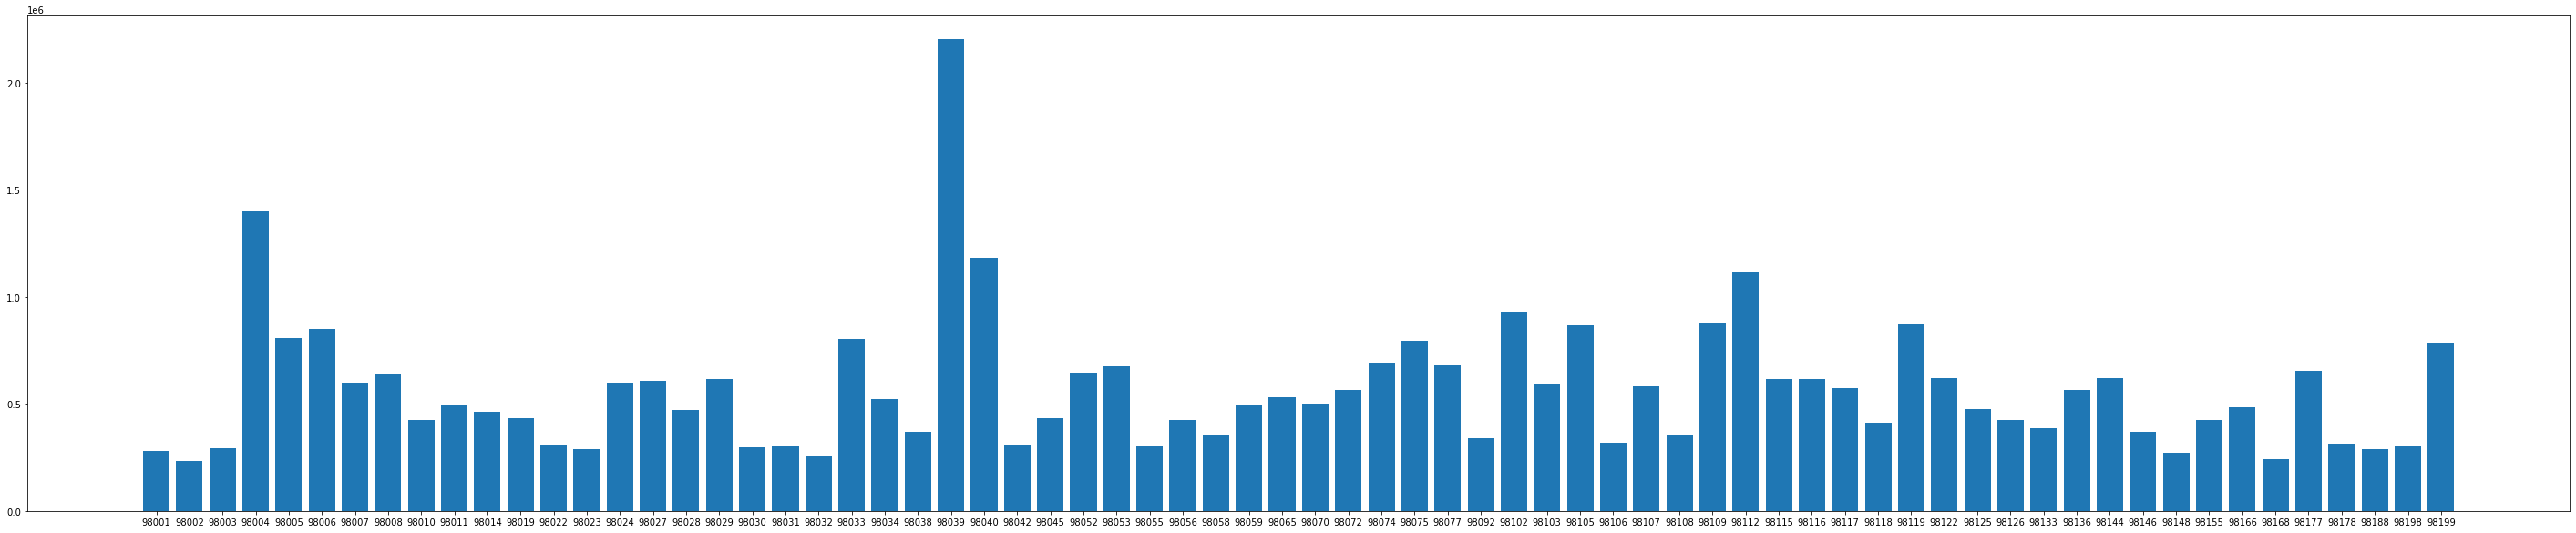

In [32]:
groupedZip = kings_county_df.groupby('zipcode')['price'].mean()

fig, ax = plt.subplots(figsize=(50,10))
ax.bar(x = groupedZip.index,
        height = groupedZip.values)


In [33]:
kings_county_df.waterfront.value_counts()

0    17088
1      134
Name: waterfront, dtype: int64

Check for any correlation

In [34]:
kings_county_df.corr()>.9

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [35]:
categorical = ['condition','grade_cat',
               'view','bedrooms', 'bathrooms','floors','zipcode']

Create dummy variables for categoricals

In [36]:
kings_county_df_w_dummies = pd.get_dummies(kings_county_df, columns=categorical, drop_first=True)
kings_county_df_w_dummies.head()

,date,price,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,view_1,view_2,view_3,view_4,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,0,8,2070,0,1986,0,2390,7700,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,0,8,1830,1070,1977,0,2370,6283,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,0,11,3770,0,1997,0,3710,9685,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,0,12,4560,0,1990,0,4050,14226,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,0,9,2550,0,2004,0,2250,4050,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


View amount of houses by zip code

In [37]:
kings_county_df_w_dummies.iloc[:, 49:].sum().sort_values()

zipcode_98039     42
zipcode_98148     43
zipcode_98024     64
zipcode_98010     74
zipcode_98102     79
zipcode_98109     85
zipcode_98070     94
zipcode_98014     98
zipcode_98032    101
zipcode_98188    108
zipcode_98007    122
zipcode_98005    140
zipcode_98019    143
zipcode_98119    148
zipcode_98108    149
zipcode_98002    157
zipcode_98077    161
zipcode_98011    163
zipcode_98105    170
zipcode_98045    175
zipcode_98022    187
zipcode_98030    201
zipcode_98166    207
zipcode_98055    209
zipcode_98107    211
zipcode_98168    213
zipcode_98178    213
zipcode_98136    214
zipcode_98031    214
zipcode_98072    215
zipcode_98112    216
zipcode_98177    218
zipcode_98028    218
zipcode_98198    219
zipcode_98003    224
zipcode_98008    226
zipcode_98040    229
zipcode_98122    235
zipcode_98004    237
zipcode_98146    240
zipcode_98065    247
zipcode_98029    250
zipcode_98106    265
zipcode_98199    266
zipcode_98116    266
zipcode_98144    269
zipcode_98126    275
zipcode_98092

Get all zips in a list

In [38]:
all_zips = list((kings_county_df.groupby('zipcode').price.mean().sort_index(ascending=True)).index)[1:]
all_zips = ['zipcode_' + sub for sub in all_zips]


Check for outliers in price

<AxesSubplot:>

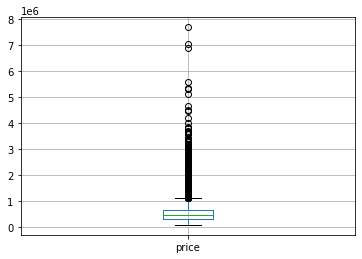

In [39]:
kings_county_df_w_dummies.boxplot(['price'],)

In [40]:
kings_county_df_w_dummies.sort_values('price', ascending=False)

,date,price,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,view_1,view_2,view_3,view_4,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
10366,2014-10-13,7700000.0,12050,27600,0,13,8570,3480,1910,1987,3940,8800,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6903,2014-06-11,7062500.0,10040,37325,1,11,7680,2360,1940,2001,3930,25449,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7519,2014-09-19,6885000.0,9890,31374,0,13,8860,1030,2001,0,4540,42730,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2232,2014-08-04,5570000.0,9200,35069,0,13,6200,3000,2001,0,3560,24345,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1979,2015-04-13,5350000.0,8000,23985,0,12,6720,1280,2009,0,4600,21750,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15650,2015-04-30,84000.0,700,20130,0,6,700,0,1949,0,1490,18630,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3430,2014-05-29,83000.0,900,8580,0,5,900,0,1918,0,2060,6533,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1269,2014-0

In [41]:
above_10std = kings_county_df_w_dummies.price.mean()+(10*kings_county_df_w_dummies.price.std())
above_10std



4277083.458190033

In [42]:
kings_county_df_w_dummies.shape

(17222, 118)

Remove the outliers more than 10 std

In [43]:
kings_county_df_w_dummies = kings_county_df_w_dummies[(kings_county_df_w_dummies['price']<=above_10std)]

kings_county_df_w_dummies[(kings_county_df_w_dummies['price']<=above_10std)].shape


(17212, 118)

### Feature Engineering

Created a few new columns: <br>
    
    - Age as in age of the house
    - Converted yr_built to a datetime obj
    - Created a bool column for if a house was renovated
    - Created a column for the month the house was sold
    - Created a column for the year the house was sold
    - Created a column for the season the house was sold
    

In [44]:
kings_county_df_w_dummies.head()

,date,price,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,view_1,view_2,view_3,view_4,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,0,8,2070,0,1986,0,2390,7700,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,0,8,1830,1070,1977,0,2370,6283,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,0,11,3770,0,1997,0,3710,9685,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,0,12,4560,0,1990,0,4050,14226,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,0,9,2550,0,2004,0,2250,4050,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Create age of home column

In [45]:
kings_county_df_w_dummies['age'] = 2021 - kings_county_df.yr_built
kings_county_df_w_dummies.drop('yr_built',axis=1, inplace=True)
kings_county_df_w_dummies['age'].value_counts()


7      453
17     359
16     344
15     342
14     335
18     335
44     323
43     312
53     298
54     293
13     281
42     272
62     259
67     255
20     252
59     250
31     250
34     236
32     234
52     231
66     231
22     213
33     213
58     210
74     210
55     205
61     202
41     201
45     197
37     196
71     193
23     191
27     188
79     187
70     183
69     183
36     182
68     179
73     175
60     175
30     175
63     174
28     173
35     173
21     171
8      169
12     166
65     165
40     164
19     164
29     163
64     162
38     156
25     155
56     151
95     151
72     148
46     144
26     141
24     139
96     139
57     139
78     135
80     129
9      126
48     124
49     120
47     117
81     116
77     112
97     109
111    109
11     106
93     105
51     104
75     101
94     100
10     100
103    100
39      86
92      84
50      81
82      81
91      77
99      73
112     73
101     73
115     73
76      70
121     70
113     69

<AxesSubplot:>

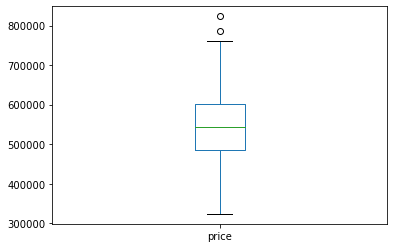

In [46]:
kings_county_df_w_dummies.groupby('age').price.mean().plot(kind='box')

Create if a home is renovated or not column

In [47]:
kings_county_df_w_dummies['is_renovated'] = np.where(kings_county_df_w_dummies['yr_renovated'] > 0, 1, 0)
kings_county_df_w_dummies.drop('yr_renovated',axis=1, inplace=True)
kings_county_df_w_dummies['is_renovated'].value_counts()


0    16492
1      720
Name: is_renovated, dtype: int64

Create column for what month the house was sold

In [48]:
kings_county_df_w_dummies['month_sold'] = kings_county_df['date'].dt.month
kings_county_df_w_dummies['month_sold'].value_counts()


5     1924
4     1799
7     1755
6     1742
8     1552
3     1490
10    1482
9     1382
12    1164
11    1151
2      983
1      788
Name: month_sold, dtype: int64

In [49]:
kings_county_df_w_dummies['year_sold'] = kings_county_df_w_dummies['date'].dt.year
kings_county_df_w_dummies['year_sold'].value_counts()

2014    11649
2015     5563
Name: year_sold, dtype: int64

In [50]:
kings_county_df_w_dummies.drop('date',axis=1, inplace=True)


In [51]:
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
#{1: Winter, 2: Spring, 3: Summer, 4: Fall}
month_to_season = dict(zip(range(1,13), seasons))
kings_county_df_w_dummies['season_sold'] = kings_county_df_w_dummies.month_sold.map(month_to_season)
kings_county_df_w_dummies['season_sold'].value_counts()


Spring    5213
Summer    5049
Fall      4015
Winter    2935
Name: season_sold, dtype: int64

In [52]:
kings_county_df_w_dummies.age.value_counts().sort_values()

86      18
87      18
119     22
120     25
88      27
89      28
6       29
85      35
118     35
117     36
107     40
83      43
108     45
90      45
104     46
84      47
114     52
106     54
110     56
116     57
100     62
105     62
98      64
109     65
102     68
113     69
121     70
76      70
99      73
112     73
115     73
101     73
91      77
82      81
50      81
92      84
39      86
103    100
10     100
94     100
75     101
51     104
93     105
11     106
97     109
111    109
77     112
81     116
47     117
49     120
48     124
9      126
80     129
78     135
57     139
96     139
24     139
26     141
46     144
72     148
95     151
56     151
25     155
38     156
64     162
29     163
19     164
40     164
65     165
12     166
8      169
21     171
35     173
28     173
63     174
60     175
73     175
30     175
68     179
36     182
69     183
70     183
79     187
27     188
23     191
71     193
37     196
45     197
41     201
61     202
55     205

<AxesSubplot:>

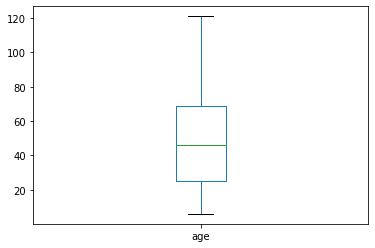

In [53]:
kings_county_df_w_dummies.age.plot(kind='box')

In [54]:
kings_county_df_w_dummies.is_renovated.value_counts()

0    16492
1      720
Name: is_renovated, dtype: int64

H0: Average price was the same across months. <br>
H1: Average price was not the same across months.

In [55]:
#alpha = .05
samples = kings_county_df_w_dummies.groupby('month_sold')['price'].apply(list)

stats.f_oneway(*samples)

F_onewayResult(statistic=2.456531020541441, pvalue=0.004582940073283766)

In [56]:
kings_county_df_w_dummies.month_sold.value_counts().sort_index()

1      788
2      983
3     1490
4     1799
5     1924
6     1742
7     1755
8     1552
9     1382
10    1482
11    1151
12    1164
Name: month_sold, dtype: int64

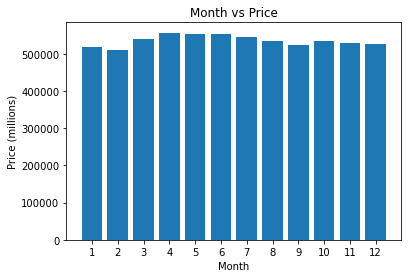

In [57]:
fig, ax = plt.subplots()
grouped = kings_county_df_w_dummies.groupby('month_sold')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Month vs Price")
ax.set_xlabel("Month")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

H0: Average price was the same across seasons <br>
H1: Average price wasn't the same across seasons

In [58]:
#alpha = .05
samples = kings_county_df_w_dummies.groupby('season_sold')['price'].apply(list)


stats.f_oneway(*samples)

F_onewayResult(statistic=6.751381519632538, pvalue=0.00015116617158790707)

In [59]:
kings_county_df_w_dummies.season_sold.value_counts()

Spring    5213
Summer    5049
Fall      4015
Winter    2935
Name: season_sold, dtype: int64

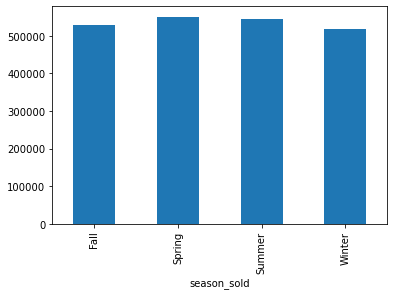

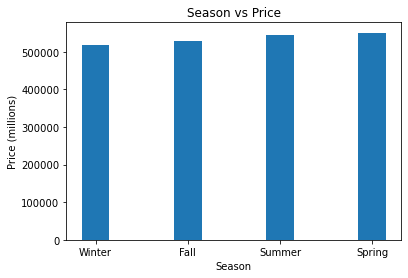

In [60]:
fig, ax = plt.subplots()
grouped = kings_county_df_w_dummies.groupby('season_sold')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values,
      width= .30)
ax.set_title("Season vs Price")
ax.set_xlabel("Season")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

H0: Average price was the same across years. <br>
H1: Average price wasn't the same across years

In [61]:
#alpha = .05

samples = kings_county_df_w_dummies.groupby('year_sold')['price'].apply(list)
stats.ttest_ind(*samples)

Ttest_indResult(statistic=-0.045280919438041155, pvalue=0.963883921278007)

In [62]:
kings_county_df_w_dummies.year_sold.value_counts()

2014    11649
2015     5563
Name: year_sold, dtype: int64

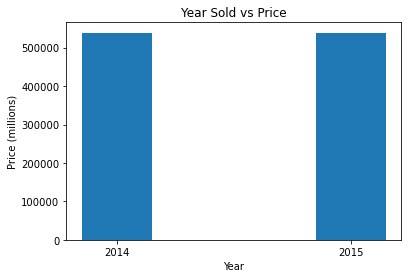

In [63]:

fig, ax = plt.subplots()
grouped = kings_county_df_w_dummies.groupby('year_sold')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values,
      width= .30)
ax.set_title("Year Sold vs Price")
ax.set_xlabel("Year")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

H0: Average price is the same with regards to grade <br>
H1: Average price isn't the same

In [64]:
samples = kings_county_df.groupby('grade')['price'].apply(list)

stats.f_oneway(*samples)

F_onewayResult(statistic=2145.209220555704, pvalue=0.0)

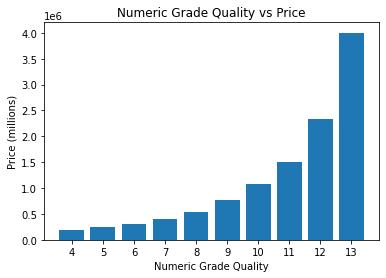

In [65]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('grade')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Numeric Grade Quality vs Price")
ax.set_xlabel("Numeric Grade Quality")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

In [66]:
samples = kings_county_df.groupby('grade_cat')['price'].apply(list)

stats.f_oneway(*samples)

F_onewayResult(statistic=4783.642269824798, pvalue=0.0)

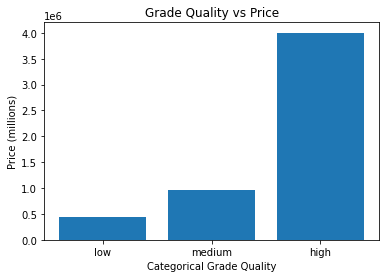

In [67]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('grade_cat')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Grade Quality vs Price")
ax.set_xlabel("Categorical Grade Quality")
ax.set_ylabel("Price (millions)");

H0: Average price is the same whether or not you have a view <br>
H1: Average price isn't the same whether you have a view or not

In [68]:
#alpha = .05

stats.ttest_ind(kings_county_df.query("view==True")['price'],kings_county_df.query("view == False")['price'])


Ttest_indResult(statistic=17.36902796896047, pvalue=5.939060476193163e-67)

In [69]:
kings_county_df.view.unique()

array([0, 2, 3, 4, 1])

H0: Amount of views have the same average price <br>
H1: Amount of view do not have the same average price.

In [70]:
samples = kings_county_df.groupby('view')['price'].apply(list)
stats.f_oneway(*samples)

F_onewayResult(statistic=881.3331085455491, pvalue=0.0)

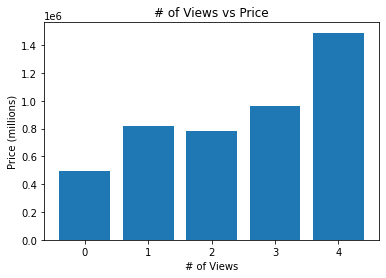

In [71]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('view')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("# of Views vs Price")
ax.set_xlabel("# of Views")
ax.set_ylabel("Price (millions)");

H0: Average price is the same whether a house is or isn't renovated <br>
H1: Average price is not the same whether a house is or isn't renovated


In [72]:
#alpha = .05
stats.ttest_ind(kings_county_df_w_dummies.query("is_renovated == True")['price'], kings_county_df_w_dummies.query("is_renovated == False")['price'])


Ttest_indResult(statistic=14.853397239367066, pvalue=1.341652365558616e-49)

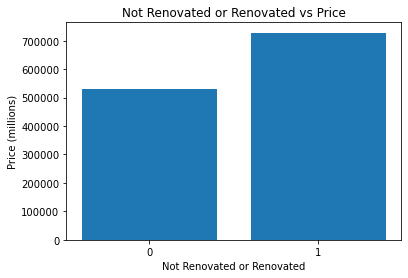

In [101]:
fig, ax = plt.subplots()
grouped = kings_county_df_w_dummies.groupby('is_renovated')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Not Renovated or Renovated vs Price")
ax.set_xlabel("Not Renovated or Renovated")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

In [75]:
kings_county_df.zipcode.unique()

array(['98058', '98115', '98006', '98034', '98052', '98031', '98007',
       '98199', '98027', '98119', '98122', '98155', '98055', '98118',
       '98014', '98059', '98004', '98053', '98072', '98133', '98092',
       '98074', '98125', '98045', '98106', '98022', '98177', '98008',
       '98002', '98040', '98029', '98042', '98001', '98065', '98056',
       '98144', '98188', '98109', '98010', '98075', '98198', '98030',
       '98105', '98023', '98028', '98112', '98038', '98116', '98103',
       '98178', '98168', '98005', '98077', '98146', '98011', '98126',
       '98108', '98136', '98033', '98003', '98117', '98107', '98019',
       '98102', '98032', '98148', '98166', '98070', '98024', '98039'],
      dtype=object)

Create dummies for season_sold as well

In [76]:
kings_county_df_w_dummies = pd.get_dummies(kings_county_df_w_dummies, columns = ['season_sold'], drop_first=True)


In [77]:
kings_county_df_w_dummies.describe()

,price,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,view_1,view_2,view_3,view_4,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,age,is_renovated,month_sold,year_sold,season_sold_Spring,season_sold_Summer,season_sold_Winter
count,1.721200e+04,17212.000000,1.721200e+04,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000,17212.000000
mean,5.387062e+05,2081.616488,1.521910e+04,0.007495,7.659133,1789.519579,292.096909,1988.434697,12843.646642,1.013247,0.007727,0.650593,0.261387,0.079015,0.803451,0.196084,0.015280,0.044562,0.023704,0.015222,0.127004,0.456251,0.318615,0.074192,0.013130,0.002847,0.067802,0.141239,0.089995,0.096793,0.250930,0.052057,0.034337,0.026435,0.034337,0.007843,0.006217,0.003718,0.004357,0.000930,0.002614,0.088310,0.378922,0.008076,0.027481,0.000349,0.009122,0.013014,0.013595,0.008134,0.022310,0.007088,0.013130,0.004299,0.009470,0.005694,0.008308,0.010865,0.023821,0.003718,0.019289,0.012666,0.014525,0.011678,0.012433,0.005868,0.020509,0.025273,0.026377,0.002324,0.013188,0.024518,0.010167,0.027539,0.018708,0.012143,0.019521,0.022252,0.021613,0.014350,0.005461,0.012491,0.020741,0.016616,0.009354

In [78]:
import statsmodels.api as sm

In [79]:
X = sm.add_constant(kings_county_df_w_dummies[['age','is_renovated','month_sold','season_sold_Spring','season_sold_Summer','season_sold_Winter']])
y = kings_county_df_w_dummies['price']
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     60.50
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           1.58e-74
Time:                        02:31:44   Log-Likelihood:            -2.4405e+05
No. Observations:               17212   AIC:                         4.881e+05
Df Residuals:                   17205   BIC:                         4.882e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.593e+05   1.38e+04     40.553      0.000    5.32e+05    5.86e+05
age                -1018.9482     92.819    -10.978      0.000   -1200.883    -837.014
is_renovated        2.303e+05   1.36e+04     16.935      0.000    2.04e+05    2.57e+05
month_sold          1062.3075   1185.250      0.896      0.370   -1260.904    3385.519
season_sold_Spring  2.861e+04   1.01e+04      2.838      0.005    8851.717    4.84e+04
season_sold_Summer  1.968e+04   8164.291      2.411      0.016    3677.473    3.57e+04
season_sold_Winter -3187.6038   9838.664     -0.324      0.746   -2.25e+04    1.61e+04
==============================================================================
Omnibus:                    11833.748   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           214293.726
Skew:                           3.104   Prob(JB):                         0.00
Kurtosis:                      19.133   Cond. No.                         416.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
kings_county_df_w_dummies.columns

Index(['price', 'sqft_living', 'sqft_lot', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'num_times_sold',
       ...
       'zipcode_98188', 'zipcode_98198', 'zipcode_98199', 'age',
       'is_renovated', 'month_sold', 'year_sold', 'season_sold_Spring',
       'season_sold_Summer', 'season_sold_Winter'],
      dtype='object', length=122)

In [81]:
kings_county_df_w_dummies['winterXsqft_living'] = kings_county_df_w_dummies['season_sold_Winter']*kings_county_df_w_dummies['sqft_living']

In [82]:
kings_county_df_w_dummies['springXsqft_living'] = kings_county_df_w_dummies['season_sold_Spring']*kings_county_df_w_dummies['sqft_living']


In [83]:
kings_county_df_w_dummies['ageXnumTimesSold'] = kings_county_df_w_dummies['age']*kings_county_df_w_dummies['num_times_sold']

In [84]:
subset =[*all_zips]

X = sm.add_constant(kings_county_df_w_dummies[subset])
y = kings_county_df_w_dummies['price']
sm.OLS(y,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     179.8
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:31:44   Log-Likelihood:            -2.3954e+05
No. Observations:               17212   AIC:                         4.792e+05
Df Residuals:                   17142   BIC:                         4.798e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.817e+05    1.6e+04     17.657      0.000     2.5e+05    3.13e+05
zipcode_98002 -4.943e+04   2.67e+04     -1.851      0.064   -1.02e+05    2926.966
zipcode_98003  9050.1450    2.4e+04      0.377      0.706    -3.8e+04    5.61e+04
zipcode_98004  1.061e+06   2.37e+04     44.733      0.000    1.01e+06    1.11e+06
zipcode_98005  5.271e+05   2.77e+04     19.008      0.000    4.73e+05    5.81e+05
zipcode_98006  5.693e+05    2.1e+04     27.075      0.000    5.28e+05    6.11e+05
zipcode_98007  3.158e+05   2.91e+04     10.865      0.000    2.59e+05    3.73e+05
zipcode_98008   3.59e+05   2.39e+04     14.995      0.000    3.12e+05    4.06e+05
zipcode_98010  1.432e+05    3.5e+04      4.085      0.000    7.45e+04    2.12e+05
zipcode_98011  2.089e+05   2.64e+04      7.917      0.000    1.57e+05    2.61e+05
zipcode_98014  1.831e+05   3.15e+04      5.819      0.000    1.21e+05    2.45e+05
zipcode_98019  1.498e+05   2.75e+04      5.439      0.000    9.58e+04    2.04e+05
zipcode_98022  2.856e+04   2.53e+04      1.129      0.259    -2.1e+04    7.81e+04
zipcode_98023  7860.1055   2.07e+04      0.379      0.705   -3.28e+04    4.85e+04
zipcode_98024  3.163e+05   3.72e+04      8.514      0.000    2.43e+05    3.89e+05
zipcode_98027  3.256e+05   2.17e+04     14.994      0.000    2.83e+05    3.68e+05
zipcode_98028  1.878e+05   2.42e+04      7.765      0.000     1.4e+05    2.35e+05
zipcode_98029   3.34e+05   2.33e+04     14.336      0.000    2.88e+05     3.8e+05
zipcode_98030  1.469e+04   2.48e+04      0.593      0.553   -3.38e+04    6.32e+04
zipcode_98031  1.863e+04   2.43e+04      0.766      0.444    -2.9e+04    6.63e+04
zipcode_98032 -2.839e+04   3.11e+04     -0.913      0.361   -8.94e+04    3.26e+04
zipcode_98033  5.089e+05   2.14e+04     23.761      0.000    4.67e+05    5.51e+05
zipcode_98034  2.422e+05   2.05e+04     11.814      0.000    2.02e+05    2.82e+05
zipcode_98038  8.699e+04   2.03e+04      4.280      0.000    4.71e+04    1.27e+05
zipcode_98039   1.72e+06   4.53e+04     37.934      0.000    1.63e+06    1.81e+06
zipcode_98040  8.678e+05   2.39e+04     36.289      0.000    8.21e+05    9.15e+05
zipcode_98042  2.738e+04   2.06e+04      1.328      0.184    -1.3e+04    6.78e+04
zipcode_98045  1.508e+05   2.58e+04      5.841      0.000       1e+05    2.01e+05
zipcode_98052  3.643e+05   2.02e+04     18.070      0.000    3.25e+05    4.04e+05
zipcode_98053  3.943e+05   2.19e+04     18.030      0.000    3.51e+05    4.37e+05
zipcode_98055  2.579e+04   2.45e+04      1.054      0.292   -2.22e+04    7.38e+04
zipcode_98056  1.418e+05   2.17e+04      6.547      0.000    9.93e+04    1.84e+05
zipcode_98058  7.348e+04    2.1e+04      3.493      0.000    3.22e+04    1.15e+05
zipcode_98059   2.13e+05   2.12e+04     10.063      0.000    1.72e+05    2.55e+05
zipcode_98065  2.475e+05   2.34e+04     10.591   

In [85]:
dummy_columns = kings_county_df_w_dummies.columns
dummy_columns.tolist() 

['price',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15',
 'num_times_sold',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_cat_low',
 'grade_cat_medium',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bedrooms_6',
 'bedrooms_7',
 'bathrooms_1.5',
 'bathrooms_1.75',
 'bathrooms_2.0',
 'bathrooms_2.25',
 'bathrooms_2.5',
 'bathrooms_2.75',
 'bathrooms_3.0',
 'bathrooms_3.25',
 'bathrooms_3.5',
 'bathrooms_3.75',
 'bathrooms_4.0',
 'bathrooms_4.25',
 'bathrooms_4.5',
 'bathrooms_4.75',
 'bathrooms_5.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_

In [86]:
subset =[*all_zips,'bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7']

X = sm.add_constant(kings_county_df_w_dummies[subset])
y = kings_county_df_w_dummies['price']
sm.OLS(y,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     213.4
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:31:45   Log-Likelihood:            -2.3855e+05
No. Observations:               17212   AIC:                         4.773e+05
Df Residuals:                   17136   BIC:                         4.778e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.011e+05   2.64e+04      3.825      0.000    4.93e+04    1.53e+05
zipcode_98002 -3.549e+04   2.52e+04     -1.406      0.160    -8.5e+04     1.4e+04
zipcode_98003  1.428e+04   2.27e+04      0.630      0.529   -3.02e+04    5.87e+04
zipcode_98004  1.016e+06   2.24e+04     45.291      0.000    9.72e+05    1.06e+06
zipcode_98005  4.821e+05   2.62e+04     18.393      0.000    4.31e+05    5.33e+05
zipcode_98006  5.259e+05   1.99e+04     26.452      0.000    4.87e+05    5.65e+05
zipcode_98007  2.826e+05   2.75e+04     10.289      0.000    2.29e+05    3.36e+05
zipcode_98008  3.234e+05   2.26e+04     14.292      0.000    2.79e+05    3.68e+05
zipcode_98010  1.476e+05   3.31e+04      4.460      0.000    8.27e+04    2.12e+05
zipcode_98011  1.916e+05   2.49e+04      7.688      0.000    1.43e+05    2.41e+05
zipcode_98014  2.178e+05   2.97e+04      7.326      0.000    1.59e+05    2.76e+05
zipcode_98019  1.465e+05    2.6e+04      5.632      0.000    9.55e+04    1.97e+05
zipcode_98022   5.65e+04   2.39e+04      2.365      0.018    9666.789    1.03e+05
zipcode_98023  7319.7852   1.96e+04      0.374      0.709   -3.11e+04    4.57e+04
zipcode_98024  3.184e+05   3.51e+04      9.077      0.000     2.5e+05    3.87e+05
zipcode_98027  3.117e+05   2.05e+04     15.198      0.000    2.72e+05    3.52e+05
zipcode_98028  1.786e+05   2.28e+04      7.821      0.000    1.34e+05    2.23e+05
zipcode_98029  3.285e+05    2.2e+04     14.934      0.000    2.85e+05    3.72e+05
zipcode_98030  4012.4661   2.34e+04      0.172      0.864   -4.18e+04    4.98e+04
zipcode_98031  5847.9631    2.3e+04      0.255      0.799   -3.92e+04    5.09e+04
zipcode_98032 -2.258e+04   2.94e+04     -0.769      0.442   -8.02e+04     3.5e+04
zipcode_98033  4.881e+05   2.02e+04     24.129      0.000    4.48e+05    5.28e+05
zipcode_98034  2.361e+05   1.94e+04     12.197      0.000    1.98e+05    2.74e+05
zipcode_98038   7.97e+04   1.92e+04      4.152      0.000    4.21e+04    1.17e+05
zipcode_98039  1.652e+06   4.29e+04     38.556      0.000    1.57e+06    1.74e+06
zipcode_98040  8.032e+05   2.26e+04     35.473      0.000    7.59e+05    8.48e+05
zipcode_98042  2.867e+04   1.95e+04      1.472      0.141   -9501.901    6.68e+04
zipcode_98045  1.726e+05   2.44e+04      7.082      0.000    1.25e+05     2.2e+05
zipcode_98052  3.389e+05    1.9e+04     17.791      0.000    3.02e+05    3.76e+05
zipcode_98053  4.079e+05   2.07e+04     19.729      0.000    3.67e+05    4.48e+05
zipcode_98055  4.089e+04   2.31e+04      1.768      0.077   -4438.744    8.62e+04
zipcode_98056   1.39e+05   2.05e+04      6.798      0.000    9.89e+04    1.79e+05
zipcode_98058  5.932e+04   1.99e+04      2.985      0.003    2.04e+04    9.83e+04
zipcode_98059  1.781e+05      2e+04      8.901      0.000    1.39e+05    2.17e+05
zipcode_98065  2.326e+05   2.21e+04     10.536   

In [87]:
subset =[*all_zips,'bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view_1','view_2','view_3','view_4', 'grade_cat_low','grade_cat_medium']

X = sm.add_constant(kings_county_df_w_dummies[subset])
y = kings_county_df_w_dummies['price']
sm.OLS(y,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     507.7
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:31:46   Log-Likelihood:            -2.3340e+05
No. Observations:               17212   AIC:                         4.670e+05
Df Residuals:                   17126   BIC:                         4.676e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.139e+06   6.97e+04     30.691      0.000       2e+06    2.28e+06
zipcode_98002       -613.5181   1.87e+04     -0.033      0.974   -3.73e+04    3.61e+04
zipcode_98003       1.564e+04   1.68e+04      0.930      0.352   -1.73e+04    4.86e+04
zipcode_98004       8.734e+05   1.67e+04     52.241      0.000    8.41e+05    9.06e+05
zipcode_98005       3.951e+05   1.95e+04     20.285      0.000    3.57e+05    4.33e+05
zipcode_98006       3.592e+05   1.48e+04     24.217      0.000     3.3e+05    3.88e+05
zipcode_98007        2.55e+05   2.04e+04     12.513      0.000    2.15e+05    2.95e+05
zipcode_98008       2.654e+05   1.68e+04     15.800      0.000    2.33e+05    2.98e+05
zipcode_98010        1.07e+05   2.45e+04      4.360      0.000    5.89e+04    1.55e+05
zipcode_98011       1.651e+05   1.85e+04      8.927      0.000    1.29e+05    2.01e+05
zipcode_98014       1.659e+05   2.21e+04      7.526      0.000    1.23e+05    2.09e+05
zipcode_98019       1.534e+05   1.93e+04      7.957      0.000    1.16e+05    1.91e+05
zipcode_98022       1.398e+04   1.78e+04      0.786      0.432   -2.09e+04    4.88e+04
zipcode_98023      -8332.8375   1.45e+04     -0.573      0.566   -3.68e+04    2.02e+04
zipcode_98024       2.467e+05    2.6e+04      9.479      0.000    1.96e+05    2.98e+05
zipcode_98027       2.493e+05   1.52e+04     16.366      0.000    2.19e+05    2.79e+05
zipcode_98028       1.607e+05   1.69e+04      9.486      0.000    1.27e+05    1.94e+05
zipcode_98029        2.43e+05   1.64e+04     14.855      0.000    2.11e+05    2.75e+05
zipcode_98030       9656.6584   1.73e+04      0.557      0.578   -2.43e+04    4.36e+04
zipcode_98031       3.137e+04    1.7e+04      1.842      0.065   -2004.083    6.48e+04
zipcode_98032       2374.2918   2.18e+04      0.109      0.913   -4.03e+04    4.51e+04
zipcode_98033       3.914e+05    1.5e+04     26.028      0.000    3.62e+05    4.21e+05
zipcode_98034       2.104e+05   1.44e+04     14.653      0.000    1.82e+05    2.39e+05
zipcode_98038         6.8e+04   1.42e+04      4.776      0.000    4.01e+04    9.59e+04
zipcode_98039       1.441e+06   3.19e+04     45.194      0.000    1.38e+06     1.5e+06
zipcode_98040       5.907e+05   1.69e+04     34.871      0.000    5.57e+05    6.24e+05
zipcode_98042       3.124e+04   1.44e+04      2.163      0.031    2930.002    5.95e+04
zipcode_98045       1.247e+05   1.81e+04      6.893      0.000    8.92e+04     1.6e+05
zipcode_98052       2.777e+05   1.42e+04     19.620      0.000     2.5e+05    3.05e+05
zipcode_98053       3.283e+05   1.54e+04     21.350      0.000    2.98e+05    3.58e+05
zipcode_98055       4.899e+04   1.71e+04      2.857      0.004    1.54e+04    8.26e+04
zipcode_98056       1.086e+05   1.52e+04      7.159      0.000    7.89e+04    1.38e+05
zipcode_98058       6.295e+04   1.47e+

In [88]:
subset =[*all_zips,'bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view_1','view_2','view_3','view_4', 'grade_cat_low','grade_cat_medium',
        'ageXnumTimesSold']

X = sm.add_constant(kings_county_df_w_dummies[subset])
y = kings_county_df_w_dummies['price']
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     502.0
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:31:46   Log-Likelihood:            -2.3339e+05
No. Observations:               17212   AIC:                         4.670e+05
Df Residuals:                   17125   BIC:                         4.676e+05
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.145e+06   6.97e+04     30.764      0.000    2.01e+06    2.28e+06
zipcode_98002       1096.8107   1.87e+04      0.059      0.953   -3.56e+04    3.78e+04
zipcode_98003       1.604e+04   1.68e+04      0.954      0.340   -1.69e+04     4.9e+04
zipcode_98004       8.757e+05   1.67e+04     52.309      0.000    8.43e+05    9.09e+05
zipcode_98005       3.975e+05   1.95e+04     20.387      0.000    3.59e+05    4.36e+05
zipcode_98006       3.604e+05   1.48e+04     24.290      0.000    3.31e+05     3.9e+05
zipcode_98007        2.57e+05   2.04e+04     12.601      0.000    2.17e+05    2.97e+05
zipcode_98008       2.674e+05   1.68e+04     15.901      0.000    2.34e+05       3e+05
zipcode_98010       1.072e+05   2.45e+04      4.369      0.000    5.91e+04    1.55e+05
zipcode_98011       1.652e+05   1.85e+04      8.934      0.000    1.29e+05    2.01e+05
zipcode_98014       1.659e+05    2.2e+04      7.525      0.000    1.23e+05    2.09e+05
zipcode_98019       1.516e+05   1.93e+04      7.856      0.000    1.14e+05    1.89e+05
zipcode_98022       1.502e+04   1.78e+04      0.845      0.398   -1.98e+04    4.99e+04
zipcode_98023      -7959.1186   1.45e+04     -0.548      0.584   -3.64e+04    2.05e+04
zipcode_98024       2.483e+05    2.6e+04      9.539      0.000    1.97e+05    2.99e+05
zipcode_98027       2.487e+05   1.52e+04     16.329      0.000    2.19e+05    2.79e+05
zipcode_98028        1.61e+05   1.69e+04      9.508      0.000    1.28e+05    1.94e+05
zipcode_98029       2.413e+05   1.64e+04     14.739      0.000    2.09e+05    2.73e+05
zipcode_98030       9267.2458   1.73e+04      0.535      0.593   -2.47e+04    4.32e+04
zipcode_98031       3.105e+04    1.7e+04      1.824      0.068   -2321.831    6.44e+04
zipcode_98032       4060.5454   2.18e+04      0.186      0.852   -3.87e+04    4.68e+04
zipcode_98033       3.922e+05    1.5e+04     26.076      0.000    3.63e+05    4.22e+05
zipcode_98034        2.11e+05   1.44e+04     14.698      0.000    1.83e+05    2.39e+05
zipcode_98038       6.595e+04   1.43e+04      4.625      0.000     3.8e+04    9.39e+04
zipcode_98039       1.444e+06   3.19e+04     45.262      0.000    1.38e+06    1.51e+06
zipcode_98040       5.931e+05    1.7e+04     34.962      0.000     5.6e+05    6.26e+05
zipcode_98042       3.039e+04   1.44e+04      2.104      0.035    2079.054    5.87e+04
zipcode_98045       1.242e+05   1.81e+04      6.865      0.000    8.87e+04     1.6e+05
zipcode_98052       2.777e+05   1.42e+04     19.620      0.000     2.5e+05    3.05e+05
zipcode_98053       3.262e+05   1.54e+04     21.194      0.000    2.96e+05    3.56e+05
zipcode_98055       5.079e+04   1.72e+04      2.960      0.003    1.72e+04    8.44e+04
zipcode_98056       1.091e+05   1.52e+04      7.190      0.000    7.94e+04    1.39e+05
zipcode_98058       6.343e+04   1.47e+

In [89]:
subset =[*all_zips,'bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view_1','view_2','view_3','view_4', 'grade_cat_low','grade_cat_medium',
        'ageXnumTimesSold']


X = sm.add_constant(kings_county_df_w_dummies[subset])
y = kings_county_df_w_dummies['price']
log_y = np.log(y)
sm.OLS(log_y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     677.0
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:31:47   Log-Likelihood:                -492.21
No. Observations:               17212   AIC:                             1158.
Df Residuals:                   17125   BIC:                             1833.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.3704      0.093    144.320      0.000      13.189      13.552
zipcode_98002         -0.0846      0.025     -3.399      0.001      -0.133      -0.036
zipcode_98003          0.0443      0.022      1.981      0.048       0.000       0.088
zipcode_98004          1.2735      0.022     57.256      0.000       1.230       1.317
zipcode_98005          0.8837      0.026     34.117      0.000       0.833       0.934
zipcode_98006          0.7804      0.020     39.585      0.000       0.742       0.819
zipcode_98007          0.6837      0.027     25.233      0.000       0.631       0.737
zipcode_98008          0.6735      0.022     30.147      0.000       0.630       0.717
zipcode_98010          0.3030      0.033      9.293      0.000       0.239       0.367
zipcode_98011          0.5139      0.025     20.918      0.000       0.466       0.562
zipcode_98014          0.4110      0.029     14.030      0.000       0.354       0.468
zipcode_98019          0.4321      0.026     16.855      0.000       0.382       0.482
zipcode_98022          0.0886      0.024      3.752      0.000       0.042       0.135
zipcode_98023          0.0030      0.019      0.154      0.877      -0.035       0.041
zipcode_98024          0.5789      0.035     16.736      0.000       0.511       0.647
zipcode_98027          0.6328      0.020     31.274      0.000       0.593       0.673
zipcode_98028          0.4788      0.023     21.276      0.000       0.435       0.523
zipcode_98029          0.6524      0.022     29.993      0.000       0.610       0.695
zipcode_98030          0.0566      0.023      2.456      0.014       0.011       0.102
zipcode_98031          0.0993      0.023      4.391      0.000       0.055       0.144
zipcode_98032         -0.0314      0.029     -1.083      0.279      -0.088       0.025
zipcode_98033          0.8231      0.020     41.197      0.000       0.784       0.862
zipcode_98034          0.5413      0.019     28.372      0.000       0.504       0.579
zipcode_98038          0.2239      0.019     11.817      0.000       0.187       0.261
zipcode_98039          1.5526      0.042     36.641      0.000       1.470       1.636
zipcode_98040          1.0103      0.023     44.824      0.000       0.966       1.054
zipcode_98042          0.0926      0.019      4.826      0.000       0.055       0.130
zipcode_98045          0.3695      0.024     15.374      0.000       0.322       0.417
zipcode_98052          0.7144      0.019     37.987      0.000       0.677       0.751
zipcode_98053          0.7714      0.020     37.717      0.000       0.731       0.811
zipcode_98055          0.1486      0.023      6.519      0.000       0.104       0.193
zipcode_98056          0.3278      0.020     16.260      0.000       0.288       0.367
zipcode_98058          0.2140      0.0